# **Chatbot Pipeline**

In [1]:
import langchain

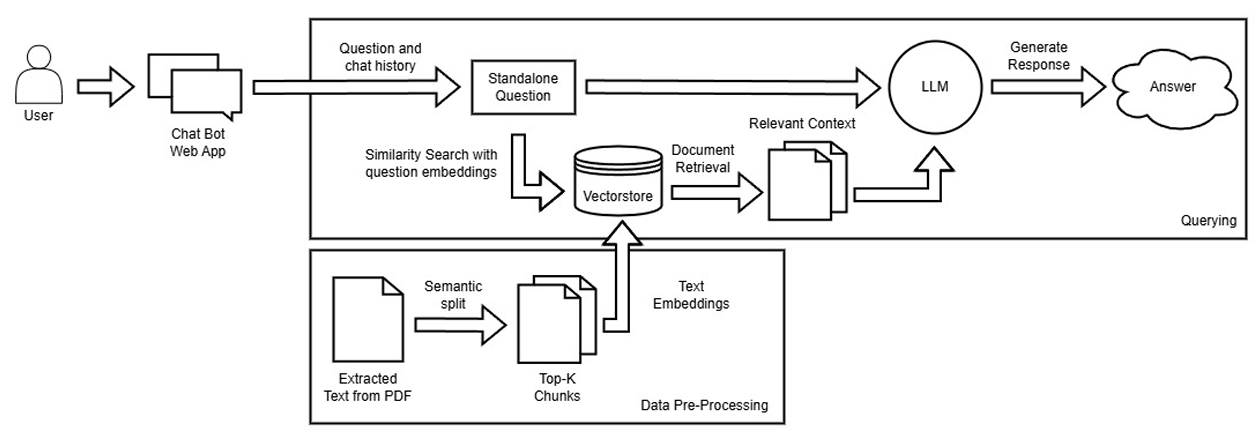

# **Access Google Drive**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter #Mengimpor alat untuk memecah teks panjang menjadi bagian-bagian kecil (chunks) berdasarkan panjang karakter.
from typing import List #Untuk deklarasi tipe data list.
from langchain_core.documents import Document #Tipe data dokumen yang digunakan LangChain. (Untuk membantu strukturisasi dokumen.)

# **Extract Text from DOCX or PDF**

In [4]:
# 1. Function to load documents from a folder
def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Lewati jika bukan file
        if not os.path.isfile(file_path):
            print(f"Skipping non-file: {filename}")
            continue

        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue

        try:
            documents.extend(loader.load())
        except Exception as e:
            print(f"Failed to load {filename}: {e}")
    return documents

In [5]:
# 2. Load documents from a folder
folder_path = "rag_dataset" # dataset folder name
documents = load_documents(folder_path)

In [6]:
for i, doc in enumerate(documents[:5]):  # tampilkan 5 dokumen pertama
    print(f"\nDokumen {i+1}")
    print(f"Nama file : {doc.metadata.get('source')}")
    print(f"Isi awal  : {doc.page_content[:300]}")  # tampilkan 300 karakter pertama


Dokumen 1
Nama file : rag_dataset\Dataset_Skripsi.docx
Isi awal  : Bab 1

Pemerintah telah mengundangkan peraturan terbaru terkait dengan Pemotongan Pajak atas Penghasilan sehubungan dengan Pekerjaan, Jasa, atau Kegiatan Orang Pribadi melalui Peraturan Pemerintah Nomor 58 Tahun 2023 dan Peraturan Menteri Keuangan Nomor 168 Tahun 2023 Terbitnya PP 58/2023 mencabut P


# **Split Text in Document into Chunks**

Best Practice text_splitter untuk deepseek-r1:7b

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # Cukup besar, tapi aman untuk reranking dan retrieval
    chunk_overlap=100,      # Untuk jaga konteks antar paragraf
    length_function=len     # Pakai len(), atau tokenizer kalau mau presisi
)

In [8]:
print(f"Loaded {len(documents)} pages from the file.")
splits = text_splitter.split_documents(documents)
print(f"Split the file content into {len(splits)} chunks.")

Loaded 1 pages from the file.
Split the file content into 146 chunks.


Mau menggunakan model huggingface

# **Embed the Text from Chunks + Vectorstore**

In [9]:
from langchain_huggingface import HuggingFaceEmbeddings
import torch

class PrefixedE5Embeddings(HuggingFaceEmbeddings):
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        texts = [f"passage: {text}" for text in texts]
        return super().embed_documents(texts)

    def embed_query(self, text: str) -> List[float]:
        return super().embed_query(f"query: {text}")

In [10]:
embedding_function = PrefixedE5Embeddings(
    model_name="intfloat/multilingual-e5-large",
    model_kwargs={"device": "cuda" if torch.cuda.is_available() else "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

document_embeddings = embedding_function.embed_documents([split.page_content for split in splits])
document_embeddings[0]

[0.029635732993483543,
 0.016453908756375313,
 -0.013058272190392017,
 0.00033203966449946165,
 0.038643255829811096,
 -0.03362919017672539,
 -0.014055364765226841,
 0.0336359404027462,
 0.046930234879255295,
 0.003850881941616535,
 0.010213758796453476,
 -0.013050439767539501,
 -0.04127408191561699,
 -0.012586277909576893,
 -0.030163981020450592,
 -0.02866058610379696,
 0.05644591525197029,
 0.03599473088979721,
 0.022206807509064674,
 0.0021103983744978905,
 0.03188767656683922,
 -0.009378786198794842,
 -0.024357710033655167,
 0.016534585505723953,
 -0.04440014809370041,
 -0.0287465900182724,
 -0.00624045031145215,
 -0.030643973499536514,
 -0.009908453561365604,
 -0.03676701337099075,
 0.007759581785649061,
 -0.010832126252353191,
 -0.03584454581141472,
 -0.03638491779565811,
 -0.05280769243836403,
 -0.0014882409013807774,
 0.04422738775610924,
 0.03545599803328514,
 -0.04100601002573967,
 0.01158833410590887,
 0.005399494431912899,
 0.03767532855272293,
 0.005970594473183155,
 -0.05

In [11]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_bge_database",  # pakai folder baru
    collection_name="beetax_collection_v2"
)

# **Rerank Retrieved Chunks**

In [12]:
def rerank_docs(query, docs, top_k=3):
    pairs = [(f"query: {query}", f"passage: {doc.page_content}") for doc in docs]
    scores = reranker.predict(pairs)
    reranked = sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)
    return [doc for doc, _ in reranked[:top_k]]

In [13]:
from sentence_transformers import CrossEncoder

query = "apa itu penghasilan tidak kena pajak?" # example question
initial_results = vectorstore.similarity_search(query, k=8)

reranker = CrossEncoder("BAAI/bge-reranker-v2-m3", device='cuda' if torch.cuda.is_available() else 'cpu')
final_results = rerank_docs(query, initial_results, top_k=3)

# 4. Print result
print(f"\nTop reranked chunks for the query: '{query}'\n")
for i, result in enumerate(final_results, 1):
    print(f"Result {i}:\n")
    print(f"Source: {result.metadata.get('source', 'Unknown')}")
    print(f"Content: {result.page_content}\n")


Top reranked chunks for the query: 'apa itu penghasilan tidak kena pajak?'

Result 1:

Source: rag_dataset\Dataset_Skripsi.docx
Content: Notes:

Penetapan tarif efektif pemotongan PPh Pasal 21 dilakukan dengan memperhatikan adanya pengurang penghasilan bruto berupa biaya jabatan atau biaya pensiun, iuran pensiun, dan Penghasilan Tidak Kena Pajak.























Bab 7: Penghasilan Tidak Kena Pajak

Penghasilan Tidak Kena Pajak (PTKP) adalah batasan penghasilan wajib pajak orang pribadi yang tidak dikenai pajak. Dengan kata lain, jika penghasilan seseorang belum melewati ambang batas PTKP, maka dia belum dikenai Pajak Penghasilan (PPh).



Tujuan dari penerapan PTKP ini adalah untuk meringankan masyarakat menengah ke bawah yang memiliki penghasilan di bawah PTKP. Hal ini karena pada dasarnya, PPh dikenakan atas Penghasilan Kena Pajak (PKP).

Result 2:

Source: rag_dataset\Dataset_Skripsi.docx
Content: Notes:

Penetapan tarif efektif pemotongan PPh Pasal 21 dilakukan dengan mempe

# **Chatbot**

In [14]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain.memory.buffer import ConversationBufferMemory
from langchain.chains import ConversationChain
import os

In [27]:
from openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv()

client = OpenAI(
  base_url = os.environ["OPENAI_BASE_URL"],
  api_key = os.environ["OPENAI_API_KEY"]
)

completion = client.chat.completions.create(
    extra_body={},
    model="deepseek/deepseek-r1:free",
    messages=[
        {
            "role": "user",
            "content": "What is the meaning of life?"
            }
    ]
)

print(completion.choices[0].message.content)

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1748736000000'}, 'provider_name': None}}, 'user_id': 'user_2xAsMMW12DrFhF71wHMV55xaNDG'}

In [15]:
llm = ChatOpenAI(
    model="deepseek/deepseek-r1:free",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    base_url=os.environ["OPENAI_BASE_URL"]
)

In [17]:
split_prompt = ChatPromptTemplate.from_template("""
You are an intelligent assistant that reformulates and splits complex user questions into distinct, clear, and standalone sub-questions.

Follow these rules:
- If multiple questions have exactly the same meaning (e.g., "what is the use?", "what's it for?"), combine them into a single sub-question.
- If questions have different intents (e.g., definition vs benefit), split them into separate sub-questions.
- Always remove duplicates or redundant versions.
- Keep the language exactly as used by the user (Bahasa Indonesia, English, etc).
- Return each unique sub-question in a numbered list format.
- Do not make up any new questions or interpretations that are not present in the user's input.
- If the input is not a question (e.g., Hello, Thank you, I'm confused, etc), return the original input, do not return empty strings or lists except when the input is empty.

Now extract the sub-questions from the following user message:

Input:
{query}

Output:
1.
""")

In [18]:
import re

def split_user_query(user_query):
    chain = split_prompt | llm | StrOutputParser()
    response = chain.invoke({"query": user_query})

    questions = [
        re.sub(r"^\d+\.\s*", "", line).strip()
        for line in response.split("\n")
        if re.match(r"^\d+\.\s+", line.strip())
    ]

    return questions

In [ ]:
def retrieve_contexts(sub_questions, vectorstore, rerank_fn, top_k=3, retrieve_k=8):
    results = []
    for sub_q in sub_questions:
        retrieved_docs = vectorstore.similarity_search(sub_q, k=retrieve_k)
        # reranked_docs = rerank_fn(sub_q, retrieved_docs, top_k)
        results.append((sub_q, retrieved_docs))
    return results

In [20]:
def combine_contexts(results):
    combined = []
    for i, (sub_q, docs) in enumerate(results, 1):
        context = "\n\n".join(f"[Doc {j+1}]: {doc.page_content}" for j, doc in enumerate(docs))
        combined.append(f"Sub-question {i}: {sub_q}\n{context}")
    return "\n\n---\n\n".join(combined)

In [21]:
tax_calc_prompt = ChatPromptTemplate.from_template("""
You are a professional tax assistant in Indonesia. Answer the following question in detail based on the [CONTEXT] provided.

If the question is related to the calculation of PPh 21 (Indonesian income tax), provide a step-by-step breakdown of the calculation systematically. If not, give a relevant explanation based on the context.

**Always respond in the same language used in the question.**

---

**Chat History:**
{chat_history}

**Question:**
{question}

**Answer:**
(Based on context. Provide calculations if relevant)

---

[CONTEXT]
{context}
""")

In [22]:
def format_chat_history(history):
    if not history:
        return "No previous conversation."
    return "\n".join([f"User: {q}\nAssistant: {a}" for q, a in history])


In [23]:
def build_rag_chain(vectorstore, rerank_fn, top_k=3, retrieve_k=8):
    def pipeline(user_query, chat_history=[]):
        history_str = format_chat_history(chat_history)

        sub_questions = split_user_query(user_query)
        docs_per_q = retrieve_contexts(sub_questions, vectorstore, rerank_fn, top_k=top_k, retrieve_k=retrieve_k)
        context_str = combine_contexts(docs_per_q)

        full_input = {
            "question": user_query,
            "context": context_str,
            "chat_history": history_str
        }

        response_chain = tax_calc_prompt | llm | StrOutputParser()
        return response_chain.invoke(full_input)

    return pipeline

In [24]:
rag_chain = build_rag_chain(vectorstore, rerank_docs)

In [25]:
chat_history = []

In [26]:
while True:
    user_query = input("Jika penghasilanku 10 juta, maka berapa pajak yang harus aku bayar?")
    response = rag_chain(user_query, chat_history=chat_history)
    
    print(response)

    chat_history.append((user_query, response))

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1748736000000'}, 'provider_name': None}}, 'user_id': 'user_2xAsMMW12DrFhF71wHMV55xaNDG'}

In [53]:
question = "Jika penghasilanku 10 juta, maka berapa pajak yang harus aku bayar?"
result = rag_chain.invoke(question)

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1748736000000'}, 'provider_name': None}}, 'user_id': 'user_2xAsMMW12DrFhF71wHMV55xaNDG'}

In [23]:
question2 = "Jika penghasilanku 2 juta, harus bayar pajak berapa?"
response2 = rag_chain.invoke(question2)
print(response2)

**Jawaban:**

Berdasarkan konteks yang diberikan dan peraturan perpajakan Indonesia, berikut penjelasan terkait pertanyaan Anda:

### **Langkah-Langkah Perhitungan PPh 21:**
1. **Penentuan Status Wajib Pajak**  
   - Jika Anda adalah **Wajib Pajak Dalam Negeri (WP-DN)**, PPh 21 diterapkan.  
   - Jika Anda adalah **Wajib Pajak Luar Negeri (WP-LN)**, PPh 26 diterapkan.  
   - Asumsi: Anda adalah WP-DN (berdasarkan pertanyaan yang umum untuk konteks Indonesia).

2. **Penghitungan Penghasilan Kena Pajak (PKP)**  
   - **Penghasilan per bulan**: Rp2.000.000.  
   - **Penghasilan per tahun**:  
     \( 2.000.000 \times 12 = 24.000.000 \).  

3. **Penentuan PTKP (Penghasilan Tidak Kena Pajak)**  
   - PTKP untuk WP-DN (status lajang/tidak menikah) pada 2023: **Rp54.000.000 per tahun**.  
   - **Perbandingan Penghasilan vs PTKP**:  
     \( 24.000.000 < 54.000.000 \).  
     **Penghasilan Anda di bawah PTKP**.

4. **Penghitungan PPh 21 Terutang**  
   - Jika penghasilan ≤ PTKP, **tidak ada PP

In [24]:
question3 = "Apa itu pajak penghasilan?"
response3 = rag_chain.invoke(question3)
print(response3)

**Jawaban:**  
Pajak Penghasilan (PPh) adalah pajak yang dikenakan atas penghasilan yang diterima atau diperoleh oleh subjek pajak, baik orang pribadi maupun badan, dalam suatu tahun pajak. Penghasilan tersebut dapat berbentuk uang, barang (natura), atau kenikstaan, termasuk penghasilan dari pekerjaan, jasa, kegiatan, atau sumber lain sesuai ketentuan perpajakan.  

### Penjelasan Konsep PPh Berdasarkan Konteks:  
1. **Bentuk Penghasilan yang Dikenakan PPh**  
   - Termasuk semua penerimaan dalam bentuk:  
     - Uang (termasuk dalam mata asing, dengan kurs yang ditetapkan saat pembayaran atau saat terutang).  
     - Natura (barang) atau kenikmatan (misalnya fasilitas).  

2. **Pengecualian PPh**  
   Beberapa jenis penghasilan tidak dikenakan PPh Pasal 21, seperti:  
   - Santunan asuransi dari perusahaan asuransi (asuransi kesehatan, kecelakaan, jiwa, dwiguna, atau beasiswa).  

3. **Subjek Pajak yang Tidak Dikenakan PPh 21/26**  
   - Penerima penghasilan tertentu tidak termasuk se

In [25]:
question4 = "Siapa saja yang harus membayar pajak penghasilan?"
response4 = rag_chain.invoke(question4)
print(response4)

**Jawaban:**

Berdasarkan konteks yang diberikan, berikut adalah pihak-pihak yang wajib membayar Pajak Penghasilan (PPh) di Indonesia:

1. **Pegawai Tetap**  
   Individu yang memiliki status sebagai karyawan tetap di suatu perusahaan atau institusi, dengan penghasilan rutin (misalnya gaji bulanan).

2. **Pensiunan**  
   Penerima pensiun atau tunjangan pensiun dari mantan pemberi kerja, baik secara rutin maupun sekaligus.

3. **Anggota Dewan Komisaris atau Dewan Pengawas**  
   Individu yang menerima imbalan tidak teratur sebagai anggota dewan komisaris, dewan pengawas, atau posisi sejenis.

4. **Pegawai Tidak Tetap**  
   Karyawan yang bekerja dengan perjanjian kontrak atau tidak memiliki status tetap, seperti pekerja harian, borongan, atau musiman.

5. **Bukan Pegawai (Non-Employee)**  
   Profesional yang bekerja secara mandiri atau memberikan jasa berdasarkan keahlian, termasuk:  
   - Pengacara  
   - Akuntan  
   - Dokter  
   - Konsultan  
   - Arsitek  
   - Notaris  
   - Pen

# **Evaluation**

In [27]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_precision,
    context_recall,
)

In [28]:
# Kumpulan pertanyaan dan jawaban dari model RAG
queries = [
    question,
    question2,
    question3,
    question4

]

responses = [
    response,   # hasil dari rag_chain.invoke(question)
    response2,
    response3,
    response4
]

retrieved_docs_all = [
    vectorstore.similarity_search(q, k=3) for q in queries
]

retrieved_contents = [
    [doc.page_content for doc in docs] for docs in retrieved_docs_all
]


In [29]:
# Ambil top 3 chunk dari retrieved contents untuk tiap query
top_k = 5
reference_answers = [
    " ".join(context_chunks[:top_k]) for context_chunks in retrieved_contents
]


In [30]:
from datasets import Dataset

data = {
    "user_input": queries,
    "response": responses,
    "retrieved_contexts": retrieved_contents,
    "reference": reference_answers
}

dataset = Dataset.from_dict(data)


In [31]:
from ragas.metrics import context_precision, context_recall, faithfulness

metrics = [faithfulness, context_precision, context_recall]

In [32]:
results = evaluate(dataset, metrics)

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

In [33]:
print("Faithfulness:", results["faithfulness"])
print("Context Precision:", results["context_precision"])
print("Context Recall:", results["context_recall"])

Faithfulness: [0.22727272727272727, 0.782608695652174, 0.56, 0.25]
Context Precision: [0.0, 0.0, 0.99999999995, 0.0]
Context Recall: [0.42857142857142855, 1.0, 0.875, 0.625]


In [34]:
faithfulness_scores = results["faithfulness"]  # ambil list nilai faithfulness per query
context_precision_scores = results["context_precision"]
context_recall_scores = results["context_recall"]

In [35]:
import numpy as np

faithfulness_mean = np.mean(faithfulness_scores)
context_precision_mean = np.mean(context_precision_scores)
context_recall_mean = np.mean(context_recall_scores)

print(f"Faithfulness (average): {faithfulness_mean:.4f}")
print(f"Context Precision (average): {context_precision_mean:.4f}")
print(f"Context Recall (average): {context_recall_mean:.4f}")

Faithfulness (average): 0.4550
Context Precision (average): 0.2500
Context Recall (average): 0.7321


In [50]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Ganti ke model instruct
model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")

# Definisikan task instruction
task_instruction = "Given a question about income taxes, retrieve relevant passages that answer the question"

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

sentence_xlm-roberta_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [51]:
query_inputs = [f"Instruct: {task_instruction}\nQuery: {q}" for q in queries]

# Dokumen tidak perlu pakai instruksi
response_inputs = responses
reference_inputs = reference_answers

# Encode
query_embeddings = model.encode(query_inputs, normalize_embeddings=True, convert_to_tensor=True)
response_embeddings = model.encode(response_inputs, normalize_embeddings=True, convert_to_tensor=True)
reference_embeddings = model.encode(reference_inputs, normalize_embeddings=True, convert_to_tensor=True)

# Hitung relevansi dan kebenaran
relevancy_scores = util.cos_sim(query_embeddings, response_embeddings).diagonal()
correctness_scores = util.cos_sim(reference_embeddings, response_embeddings).diagonal()

# Cetak skor rata-rata
print(f"Relevancy (cosine): {relevancy_scores.mean().item():.4f}")
print(f"Correctness (cosine): {correctness_scores.mean().item():.4f}")

Relevancy (cosine): 0.8914
Correctness (cosine): 0.9150


| Area                  | Diagnosis            | Saran                                                                                    |
| --------------------- | -------------------- | ---------------------------------------------------------------------------------------- |
| Context Precision     | Rendah (0.1875)      | Tambahkan **reranker** seperti `bge-reranker-v2` untuk hasil retrieval yang lebih tajam. |
| Relevancy             | Sedang (0.6407)      | Evaluasi ulang query generation dan jawaban model, serta perbaiki prompt.                |
| Faithfulness & Recall | Tinggi (> 0.85)      | Bagus. Sistem sudah faktual dan dapat menemukan informasi penting.                       |
| Correctness           | Cukup tinggi (0.80+) | Tetap bisa ditingkatkan dengan fine-tuning LLM agar lebih domain-specific (pajak).       |
